# Modeling a moving average process

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [1]:
FLT = pd.read_excel('Jianing_FLT.xlsx') # Read the excel file into a DataFrame.
print(FLT['FLT GEM Turb influent oneven'].head())   # Display the first five rows of data.


NameError: name 'pd' is not defined

In [ ]:
FLT['FLT GEM Turb influent oneven'].interpolate(method='linear',inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(FLT['Date'], FLT['FLT GEM Turb influent oneven'])
ax.set_xlabel('Time',fontsize=20)  # Label the x-axis.
ax.set_ylabel('Turbidity', fontsize=20)   # Label the y-axis.
ax.set_title('Turbidity oneven',fontsize=20)

fig.autofmt_xdate()  # Tilt the labels on the x-axis ticks so that they display nicely.
plt.tight_layout()  # Remove extra whitespace around the figure.

plt.savefig('figures/CH04_F01_peixeiro.png', dpi=300)


In [ ]:
ADF_result = adfuller(FLT['FLT GEM Turb influent oneven']) # Run the ADF test, stored in the FLT GEM Turb influent oneven column.

print(f'ADF Statistic: {ADF_result[0]}') # Print the ADF statistic.
print(f'p-value: {ADF_result[1]}') # Print the p-value.

ADF Statistic: -3.780097508622358
p-value: 0.0031176350310033745


In [ ]:
Turbidity_oneven_diff = np.diff(FLT['FLT GEM Turb influent oneven'], n=1)  # Apply first-order differencing on our data and store the result in Turbidity_oneven_diff.

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(Turbidity_oneven_diff)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Turbidity_oneven_diff (Turbidity)')


fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F05_peixeiro.png', dpi=300)

In [ ]:
ADF_result = adfuller(Turbidity_oneven_diff) # Run the ADF test on the differenced time series.

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -33.030296057704874
p-value: 0.0


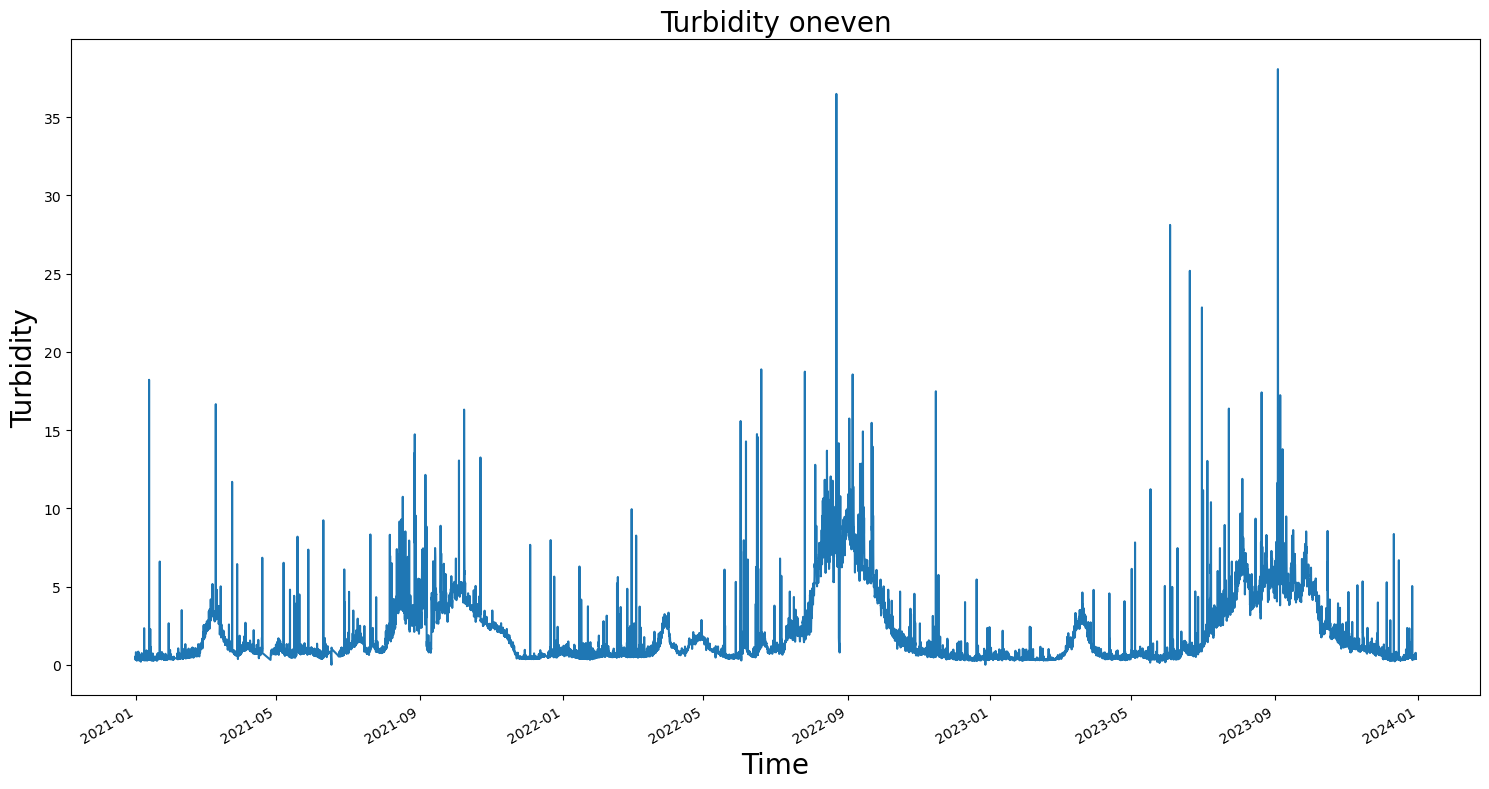

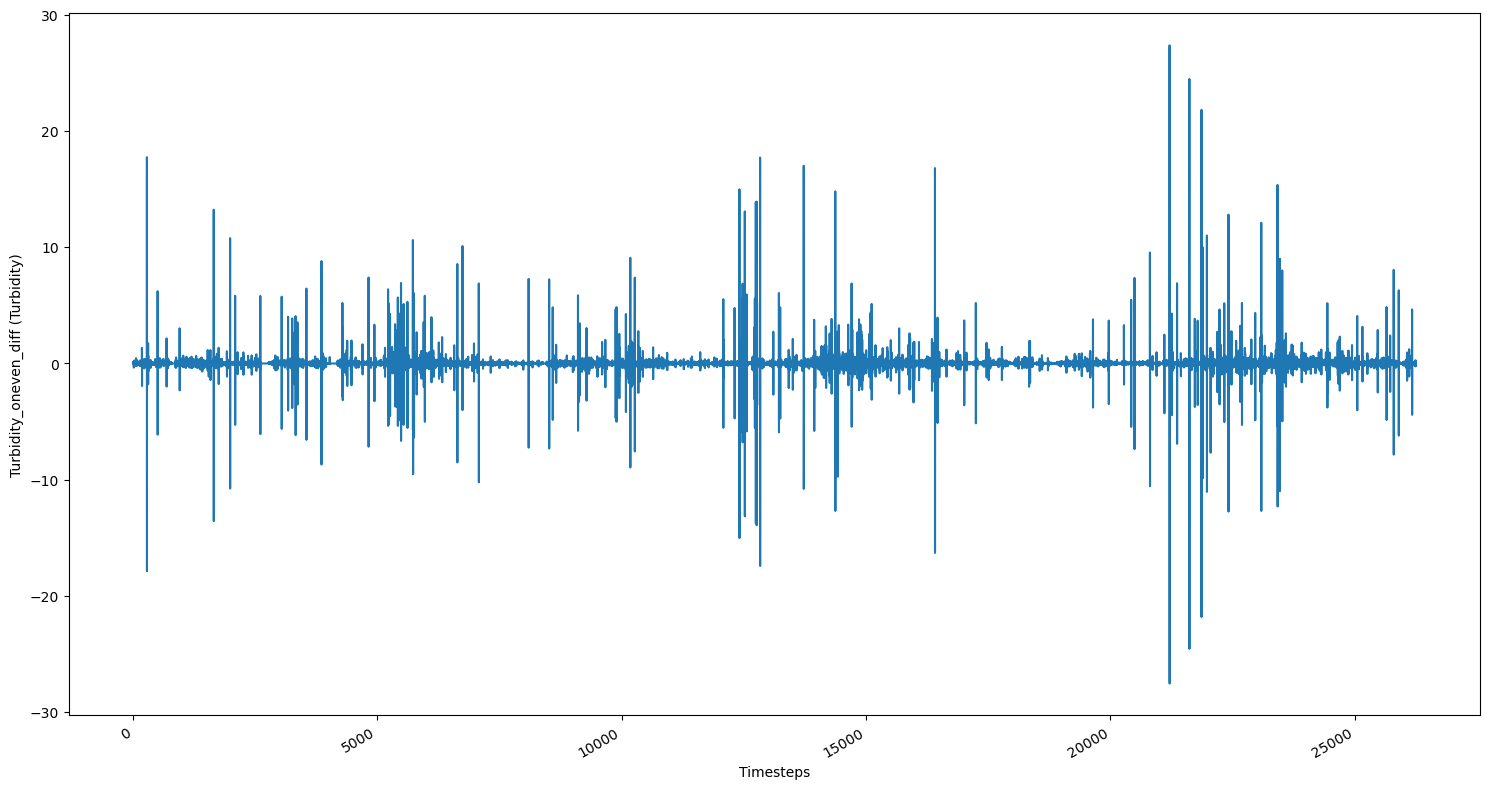

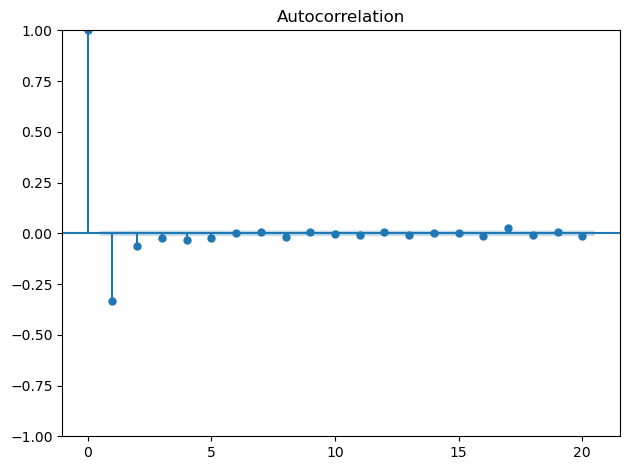

In [ ]:
plot_acf(Turbidity_oneven_diff, lags=20);   # Plot the ACF of the differenced series.

plt.tight_layout()

plt.savefig('figures/CH04_F06_peixeiro.png', dpi=300)
plt.show()
# MA(2)



## The moving average model assumes stationarity, meaning that our forecasts must be done on a stationary time series. Therefore, we will train and test our model on the differenced volume of widget sales.

In [ ]:
FLT_diff = pd.DataFrame({'Turbidity_oneven_diff': Turbidity_oneven_diff})  # Place the differenced data in a DataFrame and then split the data.

train = FLT_diff[:int(0.9*len(FLT_diff))] # The first 90% of the data goes in the training set. 
test = FLT_diff[int(0.9*len(FLT_diff)):] # The last 10% of the data goes in the test set for prediction.

print(len(train))  # 0-23624
print(len(test))  # 23625-26249

23625
2625


In [ ]:
print(train)


       Turbidity_oneven_diff
0                   0.092425
1                  -0.010766
2                  -0.061524
3                  -0.045050
4                  -0.018486
...                      ...
23620              -0.071748
23621              -0.055772
23622              -0.176135
23623              -0.211109
23624              -0.189959

[23625 rows x 1 columns]


In [ ]:
print(test)

       Turbidity_oneven_diff
23625              -0.289157
23626              -0.048007
23627               0.028880
23628               0.295269
23629               0.439201
...                      ...
26245               0.026392
26246              -0.056996
26247               0.015745
26248               0.021359
26249              -0.055870

[2625 rows x 1 columns]


In [ ]:
# Visualize the forecasting period for the differenced and original series.
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

# Original series
ax1.plot(FLT['FLT GEM Turb influent oneven'])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Turbidity oneven')
ax.axvspan(23626, 26251, color='#808080', alpha=0.2)


# Differenced series
ax2.plot(FLT_diff['Turbidity_oneven_diff'])
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Turbidity oneven diff')
ax.axvspan(23625, 26249, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F07_peixeiro.png', dpi=300)


In [ ]:
# A function for rolling forecasts on a horizon
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(FLT: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(FLT[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean[:horizon]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = FLT[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value[:horizon]
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(FLT[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA[:horizon]

In [ ]:
pred_FLT = test.copy()   # len(test): 2625

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(FLT_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')  # 2626
pred_last_value = rolling_forecast(FLT_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')  # 2626
pred_MA = rolling_forecast(FLT_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')  # 2626

pred_FLT['pred_mean'] = pred_mean
pred_FLT['pred_last_value'] = pred_last_value
pred_FLT['pred_MA'] = pred_MA

pred_FLT.head()

NameError: name 'test' is not defined

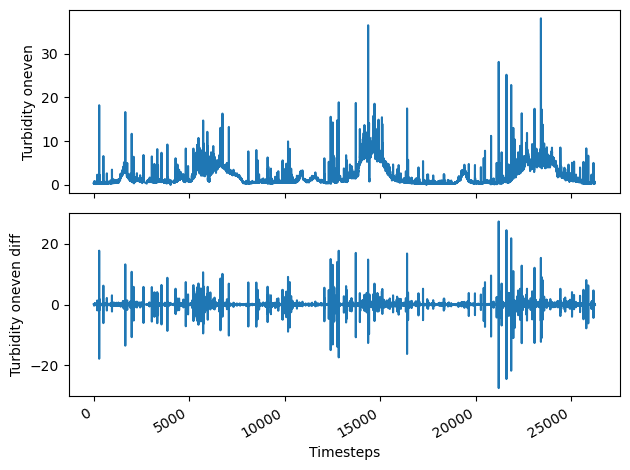

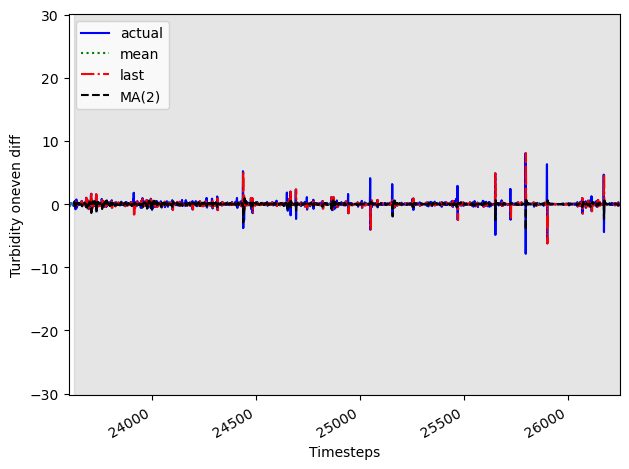

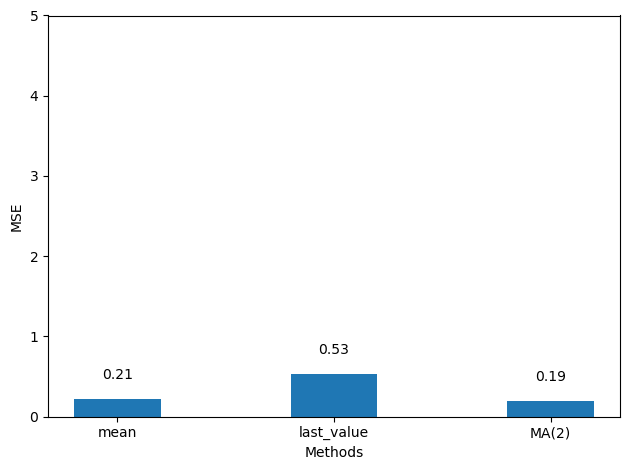

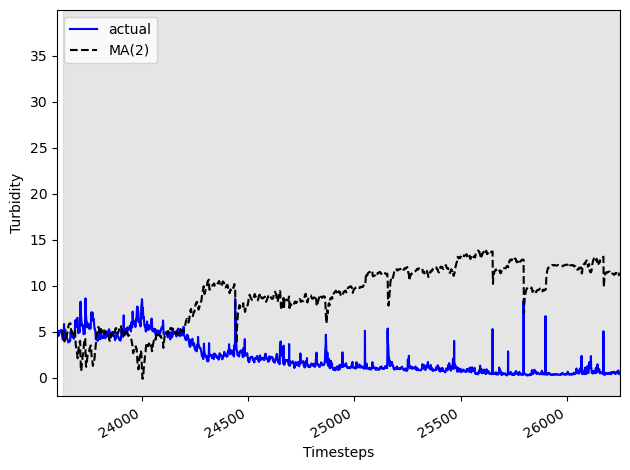

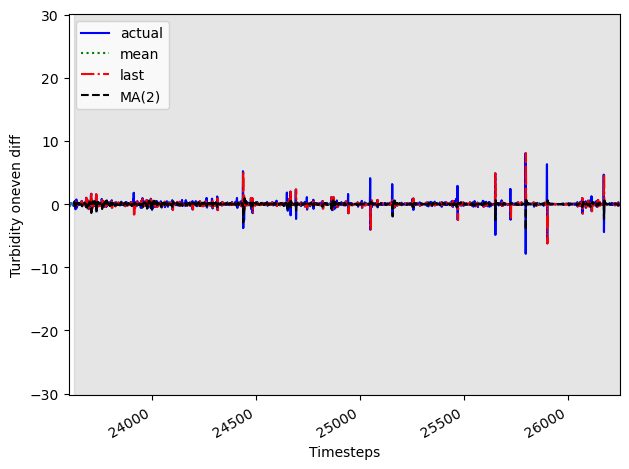

In [ ]:
fig, ax = plt.subplots()

ax.plot(FLT_diff['Turbidity_oneven_diff'])
ax.plot(pred_FLT['Turbidity_oneven_diff'], 'b-', label='actual')
ax.plot(pred_FLT['pred_mean'], 'g:', label='mean')
ax.plot(pred_FLT['pred_last_value'], 'r-.', label='last')
ax.plot(pred_FLT['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Turbidity oneven diff')

ax.axvspan(23625, 26249, color='#808080', alpha=0.2)

ax.set_xlim(20000, 26250)


fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F08_peixeiro.png', dpi=300)


In [ ]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_FLT['Turbidity_oneven_diff'], pred_FLT['pred_mean'])
mse_last = mean_squared_error(pred_FLT['Turbidity_oneven_diff'], pred_FLT['pred_last_value'])
mse_MA = mean_squared_error(pred_FLT['Turbidity_oneven_diff'], pred_FLT['pred_MA'])

print(mse_mean, mse_last, mse_MA)

0.21442144293533488 0.5320632513079424 0.18999525759822597


In [ ]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH04_F09_peixeiro.png', dpi=300)

## To obtain our predictions in the original scale of our dataset, we need to use the first value of the test as our initial value.

In [ ]:
FLT['pred_Turbidity'] = pd.Series()  # Initialize an empty column to hold our predictions.
FLT['pred_Turbidity'][23626:] = FLT['FLT GEM Turb influent oneven'].iloc[23626] + pred_FLT['pred_MA'].cumsum()

In [ ]:
fig, ax = plt.subplots()

ax.plot(FLT['FLT GEM Turb influent oneven'], 'b-', label='actual')
ax.plot(FLT['pred_Turbidity'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Turbidity')

ax.axvspan(23626, 26251, color='#808080', alpha=0.2)

ax.set_xlim(23000, 26251)


fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F11_peixeiro.png', dpi=300)

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(FLT['FLT GEM Turb influent oneven'].iloc[23626:], FLT['pred_Turbidity'].iloc[23626:])

print(mae_MA_undiff)

7.5518921534116625
